# Libraries

In [107]:
import pandas as pd
import numpy as np
import os as os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Load train data

- iterate through train data folder 
- feature engineer the **country** and **league** from parent folder name
- join the loaded csv files by rows

In [108]:
df = pd.DataFrame()
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            # Remove empty rows and columns
            tmp = tmp.dropna(how='all', axis=0)
            tmp = tmp.dropna(how='all', axis=1)
            # Derive additional columns
            tmp["league"] = int(root.split("\\")[2])
            tmp["country"] = root.split("\\")[1]
            tmp["season"] = int(file[:2]) # no. of season - 00/01 - 0th season, 21/22 - 21st season
            df = pd.concat([df, tmp], axis = 0)

df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBAHA,LBAH,LB,LB.1,LB.2,HT,AT,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,B1,20/05/01,Mechelen,Lierse,1.0,1.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B1,17/09/00,Germinal,Club Brugge,2.0,3.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B1,14/10/00,Beveren,Standard,0.0,3.0,A,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B1,06/09/00,Lokeren,Mechelen,3.0,2.0,H,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B1,27/08/00,Charleroi,Antwerp,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data validation

In some cases, the data is wrong. This section correct the loaded data.

## Not imputable data

In some cases, missing data cause the data to be unusable and can't be computed. This applies to variables

- HomeTeam
- AwayTeam

In [109]:
crucial_cols = ['Date', 'HomeTeam', 'AwayTeam']
df = df.dropna(subset = crucial_cols)

In [110]:
df[["HFKC", "AFKC"]].describe()

,HFKC,AFKC
count,1306.000000,1306.000000
mean,16.622511,17.283308
std,4.389023,4.734092
min,2.000000,2.000000
25%,14.000000,14.000000
50%,16.000000,17.000000
75%,19.750000,20.000000
max,32.000000,34.000000


## Goal validation

Some goals are incorrect and they need to be fixed.



In [111]:
goal_cols = ["FTHG", "FTAG", "HTHG", "HTAG"]
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,153476.000000,153458.000000,153426.000000,153433.000000
mean,2.221813,1.131671,0.655032,0.494333
std,21.960074,1.109022,0.808892,0.708273
min,0.000000,-1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,998.000000,13.000000,7.000000,6.000000


There seems to be several issues:

- the max value for **FTHG** is absurd
- the min value for **FTAG** does not make sense
- some values are missing

In [112]:
df["FTHG"].value_counts().head(12)

FTHG
1.0      51309
2.0      37397
0.0      35796
3.0      18313
4.0       7154
5.0       2325
6.0        741
7.0        182
8.0         41
9.0         14
10.0         5
339.0        5
Name: count, dtype: int64

First, we will remove all rows where the Full Time Home Goals are greater than 10.

In [113]:
df = df[df["FTHG"] <= 10]

Next, all Full Time Away goals that are less than zero are inspected. Since we are not sure which values are good and bad, all of them are removed.

In [114]:
df = df[df["FTAG"] >= 0]

What's left are the missing values. We have no way of recomputing these as well and these rows are again excluded.

In [115]:
df = df[df[goal_cols].isna().sum(axis=1) == 0]

If we run the describe() function again, we can see that the counts are the same and min/max statistics make sense.

In [116]:
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,152796.000000,152796.000000,152796.000000,152796.000000
mean,1.484699,1.134284,0.655096,0.494496
std,1.252576,1.107143,0.808871,0.708516
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,10.000000,13.000000,7.000000,6.000000


## Result validation

Another thing that needs to be validated is the result classification, which are re-classified - this is the easiest data validation process.

In [117]:
half_conds = [df["HTHG"] > df["HTAG"], df["HTHG"] < df["HTAG"], df["HTHG"] == df["HTAG"]]
half_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "HTR"] = np.select(half_conds, half_choic)
full_conds = [df["FTHG"] > df["FTAG"], df["FTHG"] < df["FTAG"], df["FTHG"] == df["FTAG"]]
full_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "FTR"] = np.select(full_conds, full_choic)

## Validation of other statistics

First step is to look at simple descriptive statistics.

In [118]:
stat_cols = [
    'Attendance', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW',
    'HC', 'AC', 'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', "HBP", "ABP"
]

df[stat_cols].describe()

,Attendance,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,...,HFKC,AFKC,HO,AO,HY,AY,HR,AR,HBP,ABP
count,6641.000000,91684.000000,91726.000000,90775.000000,90804.000000,6472.000000,6484.000000,91276.000000,91327.000000,89647.000000,...,1298.000000,1298.000000,6485.000000,6466.000000,91875.000000,91874.000000,91897.000000,91839.00000,6652.000000,6639.000000
mean,12853.621894,12.675352,10.296895,5.231551,4.209748,0.351823,0.260950,5.722841,4.647300,12.849644,...,16.620955,17.298921,3.258288,3.250541,1.642580,1.960413,0.087000,0.11996,15.496843,20.928604
std,13873.200798,4.925163,4.384494,2.808289,2.456644,0.610765,0.543137,2.937912,2.624468,4.556054,...,4.394704,4.740125,2.368060,2.519042,1.293023,1.365235,0.299434,0.35185,14.991016,17.225443
min,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,3530.000000,9.000000,7.000000,3.000000,2.000000,0.000000,0.000000,4.000000,3.000000,10.000000,...,14.000000,14.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,10.000000
50%,7014.000000,12.000000,10.000000,5.000000,4.000000,0.000000,0.000000,5.000000,4.000000,12.000000,...,16.000000,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,0.00000,10.000000,20.000000
75%,17608.000000,16.000000,13.000000,7.000000,6.000000,1.000000,0.000000,7.000000,6.000000,16.000000,...,20.000000,20.000000,5.000000,5.000000,2.000000,3.000000,0.000000,0.00000,20.000000,30.000000
max,69000.000000,46.000000,45.000000,27.000000,23.000000,4.000000,10.000000,26.000000,21.000000,145.000000,...,32.000000,34.000000,16.000000,18.000000,11.000000,10.000000,3.000000,9.00000,115.000000,150.000000


Then we take a look at boxplots for variables where at least one variable falls out of the interval

$$
(\text{q}_{0.25} - 3 * \text{IQR},\space \text{q}_{0.75} + 3 * \text{IQR})
$$

In [119]:
def outliers(x, multi = 3):
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    iqr = q75 - q25
    outliers = x[(x < q25 - multi * iqr) | (x > q75 + multi * iqr)]
    return len(outliers)

stat_outliers = df[stat_cols].apply(lambda x: outliers(x))
stat_outliers = stat_outliers[stat_outliers != 0]
stat_outliers

Attendance      109
HS               14
AS               23
HST              18
AST               8
AHW            1435
HC              174
AC               73
HF               21
AF               25
HO                4
AO                2
HY              633
AY                2
HR             7548
AR            10254
HBP              13
ABP              24
dtype: int64

!!!
Bylo by cool se přidat nějak jitter těch bodů, aby bylo vidět, jestli je jeden nebo je jich víc, ale nepodařilo se mi to dát dohromady.

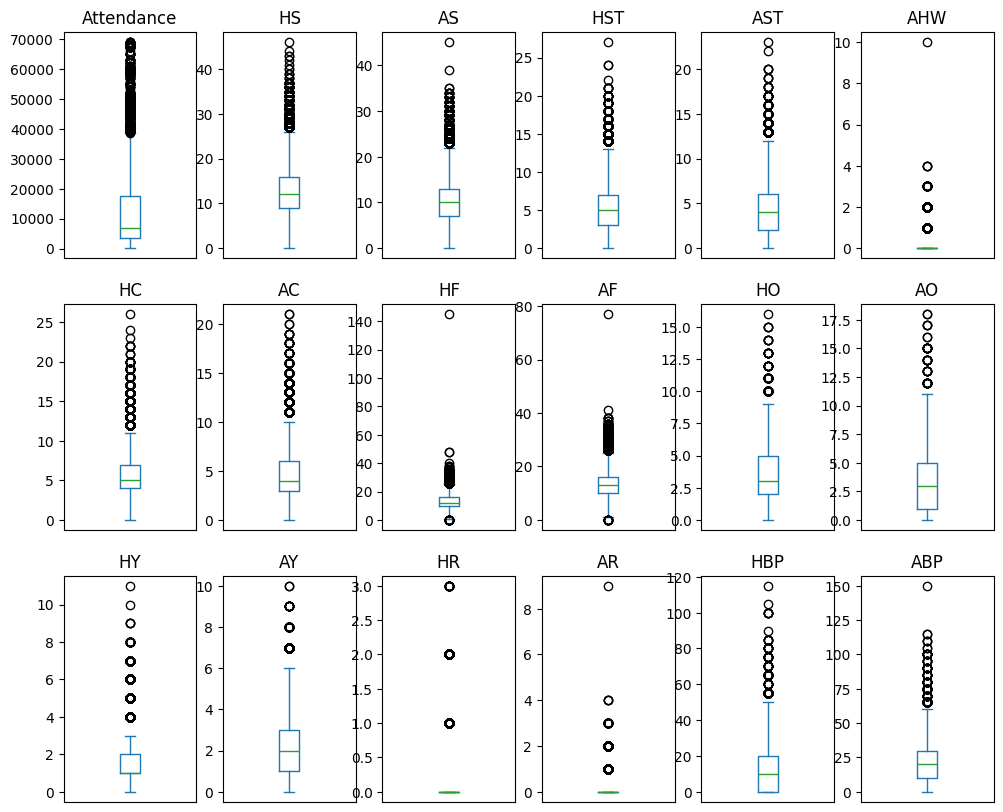

In [120]:
fig, axes = plt.subplots(nrows=3, ncols = 6, figsize = (12, 10))
axes = axes.ravel()

for i, col in enumerate(stat_outliers.index):
    # Data
    df[col].plot(kind='box', ax = axes[i])
    # Styling
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()


We can se that some outliers are not that extreme. For example variables *HO*, *AO* or *HY* have extreme values, but won't remove them. This is because even tho they can be considered as extreme, there seems to be a natural way how they occured and tehre are no huge jumps between them.

On the other hand, variables *AHW*, *HF*, *AF* and *AR* seem to have some variables that are far away from the other data. Note that we do not consider variables in *HR* as outliers because it looks like it's a discrete variable with mostly zeros.

In [121]:
stat_jump = [
    "AS", "AHW", "HF", "AF", "AR", "ABP"
]
stats_cut = [
    38, 6, 100, 60, 6, 130
]

print("Number of extreme values:")
for i, col in enumerate(stat_jump):
    cutoff = stats_cut[i]
    x = df[col].to_numpy()
    extreme = x[x > cutoff]
    print(f"{col}: {extreme}, (count: {len(extreme)})")
    
plt.show()

Number of extreme values:
AS: [45. 39.], (count: 2)
AHW: [10.], (count: 1)
HF: [145.], (count: 1)
AF: [77.], (count: 1)
AR: [9.], (count: 1)
ABP: [150.], (count: 1)


Based on the analysis, we see that these extreme values occur at most twice. This is why we chose to remove them.

In [122]:
criteria = dict(zip(stat_jump, stats_cut))
for column, value in criteria.items():
    # .isna() is important because otherwise all na rows are dropped
    df = df[df[column].lt(value) | df[column].isna()]

Finally, we will double-check with boxplots.

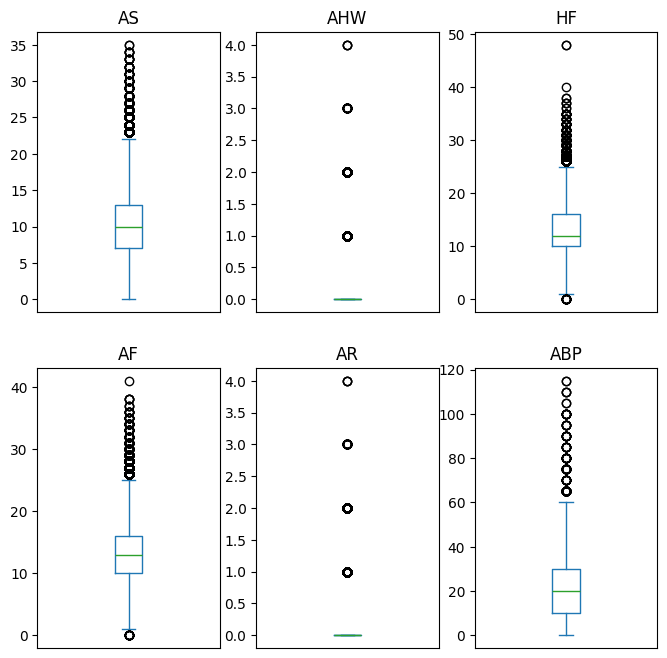

In [123]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize = (8, 8))
axes = axes.ravel()

for i, col in enumerate(stat_jump):
    # Data
    df[col].plot(kind='box', ax = axes[i])
    # Styling
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()

IT looks like variable *HF* contains another outlier, but this process should be done only once. Hence, no outliers are removed.

## Random unnamed data

File *'data/train/portugal/1/0304.csv'* contains random data in columns *'Unnamed: 33'* and *'Unnamed: 34'*.

In [124]:
unnamed_cols_df = df[['Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34']]
unnamed_cols_df[unnamed_cols_df.notnull().any(axis=1)]

,Unnamed: 32,Unnamed: 33,Unnamed: 34
157,2.0,1.8,-1.75


Since we do not know what these columns represent, and it is only one non-NA row from the whole dataset, this column is removed.

In [125]:
df = df.drop(columns = unnamed_cols_df.columns)

## Wrong betting odds names

File *'data/train/germany/2/0405.csv'* contains columns **LB**, **LB.1** and **LB.2**, which are unique only to this file. After further investigation, they represent the betting odds data for Ladbrokers. After looking at the data more thoroughly, it can be guessed that all three columns represent odds for home win, away win, and draw.

In [126]:
tmp = pd.read_csv("data/train/germany/2/0405.csv")
# Remove empty rows and columns
tmp = tmp.dropna(how='all', axis=0)
tmp = tmp.dropna(how='all', axis=1)
tmp = tmp.loc[:, ~tmp.columns.str.startswith('Unnamed:')]
tmp = tmp[tmp[['LB', 'LB.1', 'LB.2']].notnull().any(axis=1)]
tmp.filter(regex='[HDAB12]$').iloc[:, -12:]

,LB,LB.1,LB.2,SBH,SBD,SBA,WHH,WHD,WHA,GBAHH,GBAHA,GBAH
2,1.67,3.25,NaN,1.62,3.75,5.00,1.65,3.30,4.60,1.65,2.02,-0.50
6,2.00,3.20,NaN,2.10,3.20,3.25,2.15,3.10,3.00,1.77,1.95,-0.25
7,1.91,3.25,NaN,2.00,3.30,3.40,1.90,3.25,3.40,1.95,1.70,-0.50
12,2.60,3.20,2.38,2.70,3.20,2.40,2.50,3.10,2.50,1.43,2.50,0.50
15,2.25,3.20,2.75,2.40,3.00,2.88,2.20,3.10,2.87,2.30,1.48,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
291,2.40,3.25,2.50,2.50,3.25,2.50,2.45,3.25,2.45,2.45,1.43,-0.50
294,2.00,3.00,3.40,2.10,3.20,3.25,2.10,3.20,3.00,1.91,1.70,-0.50
295,2.25,3.20,2.75,2.38,3.10,2.88,2.37,3.30,2.50,2.20,1.52,-0.50
297,1.62,3.25,5.00,1.60,3.75,5.00,1.60,3.30,5.00,1.62,2.06,-0.50


Based on column similarity, we can make an edjucated guess that

- **LB** should be **LBH**,
- **LB.1** should be **LBD**, and
- **LB.2** should be **LBA**

In [127]:
# If LB is not null, use that value and replace it in LBH
df["LBH"] = df["LBH"].mask(df["LB"  ].notnull(), df["LB"])
df["LBD"] = df["LBD"].mask(df["LB.1"].notnull(), df["LB.1"])
df["LBA"] = df["LBA"].mask(df["LB.2"].notnull(), df["LB.2"])
df = df.drop(columns = ["LB", "LB.1", "LB.2"])

## Same name for different things

In some cases, columns are named differently. We will standardize to use column names that are in *'notes.txt'*


In [128]:
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            if "HT" in tmp.columns:
                print(f"Cases for HT: {root}, {file}")
            if "AT" in tmp.columns:
                print(f"Cases for AT: {root}, {file}")

Cases for HT: data/train\greece\1, 0001.csv
Cases for AT: data/train\greece\1, 0001.csv
Cases for HT: data/train\greece\1, 0102.csv
Cases for AT: data/train\greece\1, 0102.csv
Cases for HT: data/train\greece\1, 0203.csv
Cases for AT: data/train\greece\1, 0203.csv
Cases for HT: data/train\greece\1, 0304.csv
Cases for AT: data/train\greece\1, 0304.csv
Cases for HT: data/train\greece\1, 0405.csv
Cases for AT: data/train\greece\1, 0405.csv


The only affected data are in Greece.

In [129]:
df["HomeTeam"] = df["HomeTeam"].mask(df["HT"].notnull(), df["HT"])
df["AwayTeam"] = df["AwayTeam"].mask(df["AT"].notnull(), df["AT"])
df = df.drop(columns = ["HT", "AT"])

## Date normalization

Date is not consistent and it needs to be unified in order to format it as date.

In [130]:
potential_fixes = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
equal = potential_fixes[potential_fixes.isnull()].index.equals(df[df["Date"].isnull()].index)
# if True, all non-na dates have been converted
if equal:
    df["Date"] = potential_fixes
else:
    sys.exit("Date indexes are not equal. Something wrong with the conversion??")

- - -

In [131]:
df.shape

(152789, 166)

Drop all completely empty columns and rows which there is a lot of, dropped 41 empty columns in total.

In [132]:
df.dropna(how='all', axis=1, inplace=True)

In [133]:
df.shape

(152789, 166)

In [134]:
df.to_csv("final.csv")

# Data Exploration

Total overview of all variables.

In [135]:
df.describe()

,Date,FTHG,FTAG,HTHG,HTAG,GBH,GBD,GBA,IWH,IWD,...,HO,AO,HBP,ABP,SOH,SOD,SOA,LBAHH,LBAHA,LBAH
count,152789,152789.000000,152789.000000,152789.000000,152789.000000,86570.000000,86631.000000,86614.000000,148933.000000,148935.000000,...,6482.000000,6463.000000,6649.000000,6636.000000,6565.000000,6579.000000,6580.000000,5448.000000,5448.000000,5436.000000
mean,2011-07-17 12:41:28.985463552,1.484727,1.134165,0.655100,0.494460,2.273737,3.377340,3.940317,2.335584,3.381009,...,3.258099,3.251586,15.485035,20.906420,2.216587,3.391154,3.832853,1.911193,1.924781,-0.350539
min,2000-07-28 00:00:00,0.000000,0.000000,0.000000,0.000000,1.030000,1.250000,1.060000,1.010000,1.500000,...,0.000000,0.000000,0.000000,0.000000,1.060000,2.380000,1.140000,-2.250000,-0.500000,-2.250000
25%,2006-02-04 00:00:00,1.000000,0.000000,0.000000,0.000000,1.750000,3.100000,2.650000,1.750000,3.050000,...,2.000000,1.000000,0.000000,10.000000,1.700000,3.200000,2.620000,1.840000,1.840000,-0.750000
50%,2011-08-19 00:00:00,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,3.200000,...,3.000000,3.000000,10.000000,20.000000,2.050000,3.250000,3.250000,1.920000,1.920000,-0.250000
75%,2016-12-19 00:00:00,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,3.450000,...,5.000000,5.000000,20.000000,30.000000,2.400000,3.400000,4.500000,2.000000,2.000000,0.000000
max,2022-05-29 00:00:00,10.000000,9.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,16.000000,...,16.000000,18.000000,115.000000,115.000000,13.000000,8.000000,21.000000,3.400000,4.000000,9.000000
std,NaN,1.252580,1.106677,0.808874,0.708459,1.026936,0.604185,2.171809,1.150601,0.709864,...,2.368439,2.519160,14.984000,17.154701,0.985059,0.480984,2.077070,0.174244,0.124480,0.588715


Percentage of missing values.

In [136]:
na_vals = df.isna().sum()
na_vals = na_vals/df.shape[0]
na_vals.sort_values(ascending = False).head(20)

AFKC          0.991505
HFKC          0.991505
SYD           0.964494
SYH           0.964441
SYA           0.964441
LBAH          0.964422
LBAHA         0.964343
LBAHH         0.964343
AO            0.957700
HHW           0.957661
AHW           0.957582
HO            0.957575
SOH           0.957032
SOD           0.956941
SOA           0.956934
ABP           0.956568
Attendance    0.956554
HBP           0.956482
B365AH        0.955389
GBAHA         0.926520
dtype: float64

In [137]:
df = df.reset_index(drop = True)

# Get first and last occurrences
first_occurrences = df.apply(lambda x: x.first_valid_index())
last_occurrences = df.apply(lambda x: x.last_valid_index())

# Initialize a dictionary to store counts
missing_counts = {}

# Iterate through each column and calculate missing values counts between first and last occurrences
for column in df.columns:
    # Indexes of the first and last occurrences
    first_idx = df[column].first_valid_index()
    last_idx = df[column].last_valid_index()

    # Select the range between first and last occurrence, count missing values
    missing_count = df[column][first_idx:last_idx].isnull().sum()
    missing_counts[column] = missing_count

# Create a new DataFrame with the results
result_df = pd.DataFrame({
    'Variable':          df.columns,
    'First Occurrence':  df["Date"].to_numpy()[first_occurrences.values],
    'Last Occurrence':   df["Date"].to_numpy()[last_occurrences.values],
    "Missing within": missing_counts.values()
})

result_df.sort_values(by="Missing within", ascending=False)

,Variable,First Occurrence,Last Occurrence,Missing within
26,SYD,2002-05-05,2001-08-25,140984
27,SYA,2002-05-05,2001-08-25,140976
25,SYH,2002-05-05,2001-08-25,140976
34,GBAHA,2004-04-03,2004-10-24,135492
35,GBAH,2004-04-03,2004-10-24,135489
...,...,...,...,...
5,FTAG,2001-05-20,2022-05-15,0
4,FTHG,2001-05-20,2022-05-15,0
3,AwayTeam,2001-05-20,2022-05-15,0
2,HomeTeam,2001-05-20,2022-05-15,0


List of the most missing values.

In [138]:
na_vals = df[df["season"] > 18].isna().sum()

na_vals = na_vals/df[df["season"] > 18].shape[0]*100
na_vals

Div           0.0
Date          0.0
HomeTeam      0.0
AwayTeam      0.0
FTHG          0.0
            ...  
SOD         100.0
SOA         100.0
LBAHH       100.0
LBAHA       100.0
LBAH        100.0
Length: 166, dtype: float64

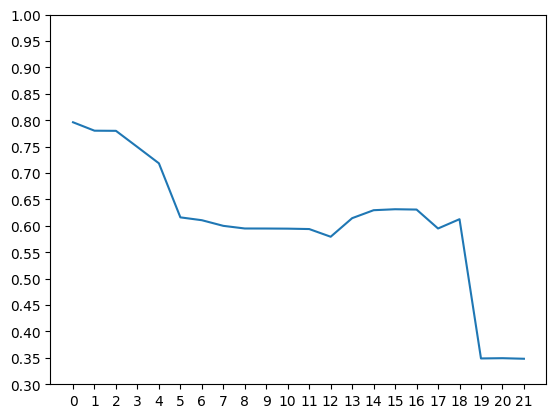

In [139]:
na_vals = [df[df["season"]==i].isna().sum().sum()/(df[df["season"]==i].shape[0]*df[df["season"]==i].shape[1]) for i in range(0,22)]
plt.xticks(range(0,22))
plt.ylim(0.3, 1)
plt.locator_params(axis='y', nbins=14)
plt.plot(na_vals)
plt.gca().ticklabel_format(axis='y', style='plain', scilimits=(0, 0))

# Feature Engineering
We decided to add several features to the dataset. 
These features are:
- Result of the last match between the two contending teams
- Goal score during the last match between the two contending teams
- Average amount of goals scored in the current season
- Average amount of goals received in the current season

We believe that these features will prove useful in the training of our model as they can reveal things such as momentum and strenghts/weaknesses against certain teams. 

### Result of the last match between the two contending teams

Create a string of participating teams, append them alphabetically behind each other so it is easier to slice them.

In [141]:
df["Index"] = df.index
df["MatchTeams"] = df[["HomeTeam","AwayTeam"]].values.tolist()
df["MatchTeams"] = df["MatchTeams"].sort_values().apply(lambda x: sorted(x))

In [142]:
df = df.assign(MatchTeams=df["MatchTeams"].apply(lambda l: "_".join(l)))

In [143]:
df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AO,HBP,ABP,SOH,SOD,SOA,LBAHH,LBAHA,LBAH,Index
147285,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147138,T1,2003-11-08,Adanaspor,A. Sebatspor,1.0,2.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147285.0
147114,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147133,T1,2003-12-21,Ankaragucu,A. Sebatspor,1.0,1.0,D,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147114.0
147436,T1,2004-05-15,A. Sebatspor,Ankaragucu,3.0,2.0,H,3.0,2.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39178,E3,2003-09-13,Yeovil,York,3.0,0.0,H,2.0,0.0,H,...,NaN,NaN,NaN,1.91,3.25,3.50,NaN,NaN,NaN,39392.0
45598,E3,2004-04-20,York,Yeovil,1.0,2.0,A,1.0,0.0,H,...,NaN,NaN,NaN,2.75,3.40,2.25,NaN,NaN,NaN,39178.0
45653,E3,2015-08-18,York,Yeovil,1.0,0.0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45598.0
146113,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Use groupby to group by same matches, create ["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"] columns with unsorted values.
First match of two teams gets empty column index as LastMatchIndex

In [148]:
df[["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"]] = df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()[["Index","FTAG", "FTHG"]]
df.loc[np.isnan(df["LastMatchIndex"]), "LastMatchIndex"] = len(df.index)-1
df.loc[len(df.index)] = [np.nan for _ in range(df.shape[1])]
df.loc[len(df.index)-1]
df["LastMatchIndex"] = df["LastMatchIndex"].replace(np.nan, len(df.index)-1)

df["LastMatchIndex"].fillna(len(df.index)-1)

C:\Users\vojta\AppData\Local\Temp\ipykernel_70740\3676423093.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df.index)] = [np.nan for _ in range(df.shape[1])]


0            117.0
1         152788.0
2         152788.0
3         152788.0
4         152788.0
            ...   
152785    152197.0
152786    152763.0
152787    152303.0
152788    152466.0
152789    152789.0
Name: LastMatchIndex, Length: 152790, dtype: float64

In [149]:
arr = df["LastMatchIndex"]

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,SOD,SOA,LBAHH,LBAHA,LBAH,Index,MatchTeams,LastMatchIndex,LastMatchAwayGoals,LastMatchHomeGoals
117,B1,2000-12-16,Lierse,Mechelen,1.0,1.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,117.0,Lierse_Mechelen,152788.0,NaN,NaN
152788,T1,2022-05-15,Trabzonspor,Altay,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,152788.0,Altay_Trabzonspor,152466.0,2.0,1.0
152788,T1,2022-05-15,Trabzonspor,Altay,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,152788.0,Altay_Trabzonspor,152466.0,2.0,1.0
152788,T1,2022-05-15,Trabzonspor,Altay,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,152788.0,Altay_Trabzonspor,152466.0,2.0,1.0
152788,T1,2022-05-15,Trabzonspor,Altay,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,152788.0,Altay_Trabzonspor,152466.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152197,T1,2021-02-04,Goztep,Yeni Malatyaspor,2.0,2.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,152197.0,Goztep_Yeni Malatyaspor,152182.0,1.0,1.0
152763,T1,2021-11-26,Buyuksehyr,Altay,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,152763.0,Altay_Buyuksehyr,152788.0,NaN,NaN
152303,T1,2021-03-21,Besiktas,Fenerbahce,1.0,1.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,152303.0,Besiktas_Fenerbahce,152226.0,4.0,3.0
152466,T1,2021-12-21,Altay,Trabzonspor,1.0,2.0,A,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,152466.0,Altay_Trabzonspor,146767.0,4.0,1.0


Switch LastMatchHomeGoals and LastMatchAwayGoals if they do not correspond to the teams accordingly, calculate who won the match

In [197]:
df["SameHomeTeam"] = (df.iloc[arr]["HomeTeam"].values == df["HomeTeam"].values)
df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']] = df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']].values
df["LastMatchAwayWin"] = (df["LastMatchAwayGoals"] > df["LastMatchHomeGoals"]).astype(int)
df["LastMatchHomeWin"] = (df["LastMatchAwayGoals"] < df["LastMatchHomeGoals"]).astype(int)
df["LastMatchDraw"] = (df["LastMatchAwayGoals"] == df["LastMatchHomeGoals"]).astype(int)

In [201]:
df[df["MatchTeams"] == "Chelsea_Liverpool"][["Date","FTHG", "FTAG","LastMatchHomeGoals", "LastMatchAwayGoals", "LastMatchHomeWin","LastMatchAwayWin", "LastMatchDraw" ]]
df.drop(["SameHomeTeam", "LastMatchIndex", "Index"], axis=1)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,SOA,LBAHH,LBAHA,LBAH,MatchTeams,LastMatchAwayGoals,LastMatchHomeGoals,LastMatchAwayWin,LastMatchHomeWin,LastMatchDraw
0,B1,2001-05-20,Mechelen,Lierse,1.0,1.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,Lierse_Mechelen,1.0,1.0,0,0,1
1,B1,2000-09-17,Germinal,Club Brugge,2.0,3.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,Club Brugge_Germinal,NaN,NaN,0,0,0
2,B1,2000-10-14,Beveren,Standard,0.0,3.0,A,0.0,2.0,A,...,NaN,NaN,NaN,NaN,Beveren_Standard,NaN,NaN,0,0,0
3,B1,2000-09-06,Lokeren,Mechelen,3.0,2.0,H,0.0,2.0,A,...,NaN,NaN,NaN,NaN,Lokeren_Mechelen,NaN,NaN,0,0,0
4,B1,2000-08-27,Charleroi,Antwerp,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,Antwerp_Charleroi,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152785,T1,2021-08-22,Goztep,Yeni Malatyaspor,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,Goztep_Yeni Malatyaspor,2.0,2.0,0,0,1
152786,T1,2022-04-16,Altay,Buyuksehyr,1.0,1.0,D,0.0,1.0,A,...,NaN,NaN,NaN,NaN,Altay_Buyuksehyr,0.0,0.0,0,0,1
152787,T1,2021-12-19,Fenerbahce,Besiktas,2.0,2.0,D,2.0,1.0,H,...,NaN,NaN,NaN,NaN,Besiktas_Fenerbahce,1.0,1.0,0,0,1
152788,T1,2022-05-15,Trabzonspor,Altay,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,Altay_Trabzonspor,2.0,1.0,1,0,0


# Average amount of goals scored/received in the current season

We will add 4 columns - HomeTeamAvgScored, AwayTeamAvgScored, HomeTeamAvgReceived, AwayTeamAvgReceived


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBAH,Index,MatchTeams,LastMatchIndex,LastMatchAwayGoals,LastMatchHomeGoals,SameHomeTeam,LastMatchAwayWin,LastMatchHomeWin,LastMatchDraw
0,B1,2001-05-20,Mechelen,Lierse,1.0,1.0,D,1.0,1.0,D,...,NaN,0.0,Lierse_Mechelen,117.0,1.0,1.0,False,0,0,1
5842,E0,2001-01-13,Middlesbrough,Derby,4.0,0.0,H,1.0,0.0,H,...,NaN,5842.0,Derby_Middlesbrough,6026.0,3.0,3.0,False,0,0,1
5841,E0,2001-04-28,Coventry,Liverpool,0.0,2.0,A,0.0,0.0,D,...,NaN,5841.0,Coventry_Liverpool,5962.0,1.0,4.0,False,0,1,0
5840,E0,2000-09-09,Bradford,Arsenal,1.0,1.0,D,1.0,0.0,H,...,NaN,5840.0,Arsenal_Bradford,152788.0,NaN,NaN,False,0,0,0
5839,E0,2001-01-20,Man United,Aston Villa,2.0,0.0,H,0.0,0.0,D,...,NaN,5839.0,Aston Villa_Man United,6107.0,1.0,0.0,False,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48719,E3,2021-10-09,Forest Green,Swindon,0.0,2.0,A,0.0,0.0,D,...,NaN,48719.0,Forest Green_Swindon,47776.0,2.0,0.0,False,1,0,0
48714,E3,2021-11-20,Barrow,Crawley Town,0.0,1.0,A,0.0,0.0,D,...,NaN,48714.0,Barrow_Crawley Town,48280.0,2.0,3.0,True,0,1,0
48713,E3,2021-08-28,Harrogate,Exeter,1.0,1.0,D,1.0,0.0,H,...,NaN,48713.0,Exeter_Harrogate,48416.0,0.0,0.0,True,0,0,1
48712,E3,2021-10-09,Walsall,Salford,2.0,1.0,H,1.0,0.0,H,...,NaN,48712.0,Salford_Walsall,48242.0,2.0,0.0,True,1,0,0
